In [1]:
#load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [7]:
#load dataset
df = pd.read_csv('dataset/consensus_adj_mat.csv')
df.head()
df = df.drop(columns=['Unnamed: 0'])

print(df)

    Akt  Erk  Jnk  Mek  P38  PIP2  PIP3  PKA  PKC  Plcg  Raf
0     0    0    0    0    0     0     0    0    0     0    0
1     0    0    0    0    0     0     0    0    0     0    0
2     0    0    0    0    0     0     0    0    0     0    0
3     0    1    0    0    0     0     0    0    0     0    0
4     0    0    0    0    0     0     0    0    0     0    0
5     0    0    0    0    0     0     0    0    1     0    0
6     1    0    0    0    0     1     0    0    0     1    0
7     1    1    1    1    1     0     0    0    0     0    1
8     0    0    1    1    1     0     0    0    0     0    1
9     0    0    0    0    0     1     0    0    1     0    0
10    0    0    0    1    0     0     0    0    0     0    0


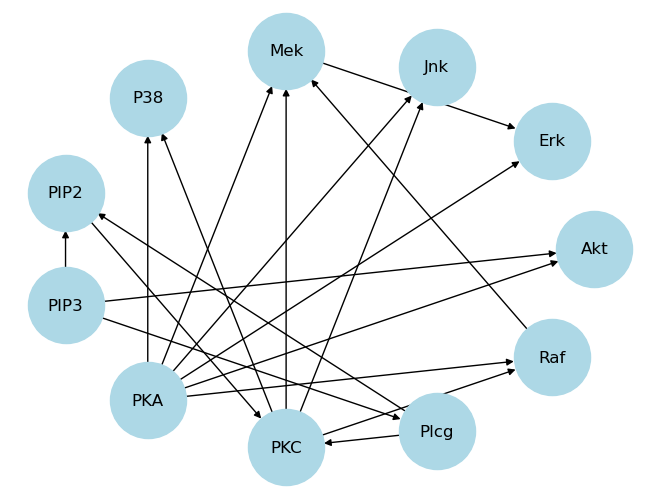

['Akt', 'Erk', 'Jnk', 'Mek', 'P38', 'PIP2', 'PIP3', 'PKA', 'PKC', 'Plcg', 'Raf']
[('Mek', 'Erk'), ('PIP2', 'PKC'), ('PIP3', 'Akt'), ('PIP3', 'PIP2'), ('PIP3', 'Plcg'), ('PKA', 'Akt'), ('PKA', 'Erk'), ('PKA', 'Jnk'), ('PKA', 'Mek'), ('PKA', 'P38'), ('PKA', 'Raf'), ('PKC', 'Jnk'), ('PKC', 'Mek'), ('PKC', 'P38'), ('PKC', 'Raf'), ('Plcg', 'PIP2'), ('Plcg', 'PKC'), ('Raf', 'Mek')]


In [6]:
#plot the causal dag so the nodes lie in a circle
G = nx.DiGraph()
G.add_nodes_from(df.columns)
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if df.iloc[i,j] == 1:
            G.add_edge(df.columns[i],df.columns[j])

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue')
plt.show()

print(G.nodes)
print(G.edges)